In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True, font_scale=0.8)

import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

%matplotlib inline

In [2]:
# Load the ysi / nsp database in which I've already inputed the SMILES strings
ysi_nsp = pd.read_csv('ysi_vs_nsp.csv')

from fragdecomp.chemical_conversions import canonicalize_smiles
ysi_nsp['SMILES'] = ysi_nsp.SMILES.apply(canonicalize_smiles)

# Calculate the fragment decomposition for the nsp molecules
from fragdecomp.fragment_decomposition import get_fragments
nsp_frags = ysi_nsp.SMILES.apply(get_fragments).fillna(0).astype(int)

# Set smiles strings as the index
nsp_frags.index = ysi_nsp.SMILES
ysi_nsp.set_index('SMILES', inplace=True)

In [3]:
# Re-preform the ysi-regression
ysi = pd.read_csv('ysi.csv').set_index('SMILES')
fragments = pd.read_csv('fragments.csv', index_col=0)

err = ysi.YSI_err**2

from fragdecomp.regression import BayesianRegressionOutlier
reg = BayesianRegressionOutlier(fragments.values, ysi.YSI, err, prior_sd=25)
sigma, beta, y_hat = reg.sample(1000)

/Users/pstjohn/Dropbox/nrel_documents/Papers/stitching-paper/model/fragdecomp/regression.py:38: UserWarning: X Matrix is not full-rank
  warn("X Matrix is not full-rank")


In [4]:
# All of the fragments found in the NSP database are also found in the YSI database
assert nsp_frags.columns.isin(fragments.columns).all()

In [5]:
# Need to put the new fragments in the same shape as the YSI fragments
indexed_nsp_frags = nsp_frags.loc[:, fragments.columns].fillna(0).astype(int).values

# Perform the regression
y_pred, y_hpd = reg.predict(indexed_nsp_frags, beta)
y_outlier = reg.is_outlier(indexed_nsp_frags)
hpd_range = y_hpd.sum(1)

In [6]:
ysi_nsp[y_outlier]

,Compound,NSP,NSP_Error,YSI,YSI_Error,Type
SMILES,,,,,,
C1CC1,Cyclopropane,25.9,0.0,NaN,NaN,Alkane


Only outlier is cyclopropane, even though that fragment appears in cyclopropyl benzene

In [7]:
ysi_nsp['YSI_method'] = 'experimental'

# index the non-measured nsp's
missing_entries = ysi_nsp.YSI.isnull()

# fill in missing entries from the regression
ysi_nsp.loc[missing_entries, 'YSI_method'] = 'regressed'
ysi_nsp.loc[missing_entries, 'YSI'] = y_pred[missing_entries.values]
ysi_nsp.loc[missing_entries, 'YSI_Error'] = hpd_range[missing_entries.values]

In [8]:
# Drop cyclopropane
ysi_nsp.loc['C1CC1', ['YSI', 'YSI_Error']] = np.nan

In [9]:
ysi_nsp.to_csv('data/ysi_nsp_predictions.csv')
ysi_nsp.head()

,Compound,NSP,NSP_Error,YSI,YSI_Error,Type,YSI_method
SMILES,,,,,,,
CC,Ethane,319.0,153.0,10.544666,6.570548,Alkane,regressed
C1CC1,Cyclopropane,25.9,0.0,NaN,NaN,Alkane,regressed
CCC,Propane,202.0,82.0,16.526663,5.841908,Alkane,regressed
CCCC,n-Butane,175.0,33.0,22.548611,5.149965,Alkane,regressed
CC(C)C,Isobutane,96.3,0.0,27.300961,4.656482,Alkane,regressed


In [56]:
ysi_nsp[ysi_nsp.Compound.str.contains('[Bb]enzene')]

,Compound,NSP,NSP_Error,YSI,YSI_Error,Type,YSI_method
SMILES,,,,,,,
c1ccccc1,Benzene,8.79,1.66,100.000000,5.800000,Aromatic,experimental
CCc1ccccc1,Ethylbenzene,5.92,1.00,223.700000,9.300000,Aromatic,experimental
Cc1cc(C)cc(C)c1,Trimethylbenzenes,6.43,1.17,311.700000,12.300000,Aromatic,experimental
CCCc1ccccc1,n-Propylbenzene,6.86,1.90,235.700000,9.900000,Aromatic,experimental
CCCCc1ccccc1,n-Butylbenzene,7.39,2.12,245.100000,9.900000,Aromatic,experimental
CCC(C)c1ccccc1,sec-Butylbenzene,6.97,1.69,199.100000,8.700000,Aromatic,experimental
CC(C)(C)c1ccccc1,tert-Butylbenzene,4.37,0.00,291.100000,11.600000,Aromatic,experimental
CC(C)Cc1ccccc1,Isobutylbenzene,7.41,2.54,257.600000,10.500000,Aromatic,experimental
CCc1ccccc1CC,Diethylbenzene,6.11,0.00,376.300000,14.700000,Aromatic,experimental


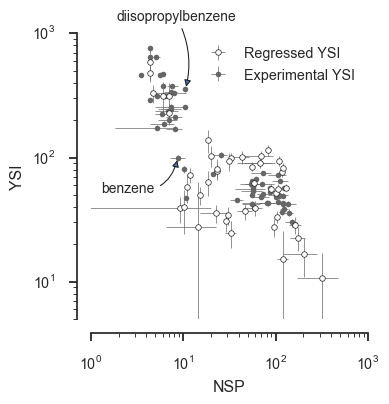

In [100]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)


df = ysi_nsp[ysi_nsp.YSI_method == 'regressed']
# df = ysi_nsp
ax.errorbar(df.NSP, df.YSI, xerr=1.96*df.NSP_Error/2, yerr=1.96*df.YSI_Error/2,
            ls='', color='.4', fmt='o', mfc='white', markeredgewidth=.5, ms=4, elinewidth=0.5, label='Regressed YSI',
            zorder=1,
            capsize=0)

df = ysi_nsp[ysi_nsp.YSI_method == 'experimental']
ax.errorbar(df.NSP, df.YSI, xerr=1.96*df.NSP_Error/2, yerr=1.96*df.YSI_Error/2,
            ls='', marker='o', color='.4', ms=4, elinewidth=0.5, label='Experimental YSI', zorder=0)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([5, 1000])
ax.legend(loc='upper right')

ax.set_ylabel('YSI')
ax.set_xlabel('NSP')

ipb = df.loc['CC(C)c1cccc(C(C)C)c1']
ax.annotate('diisopropylbenzene', xy=(ipb.NSP, ipb.YSI), xycoords='data',
            xytext=(-50, 50), textcoords="offset points",
            arrowprops=dict(
                arrowstyle="-|>",
                connectionstyle="arc3,rad=-0.2",
                lw=.75),)

benz = df.loc['c1ccccc1']
ax.annotate('benzene', xy=(benz.NSP, benz.YSI), xycoords='data',
            xytext=(-55, -25), textcoords="offset points",
            arrowprops=dict(
                arrowstyle="-|>",
                connectionstyle="arc3,rad=0.5",
                lw=.75),)

sns.despine(offset=10)
fig.tight_layout()

fig.savefig('figures/ysi_vs_nsp.svg', transparent=True)

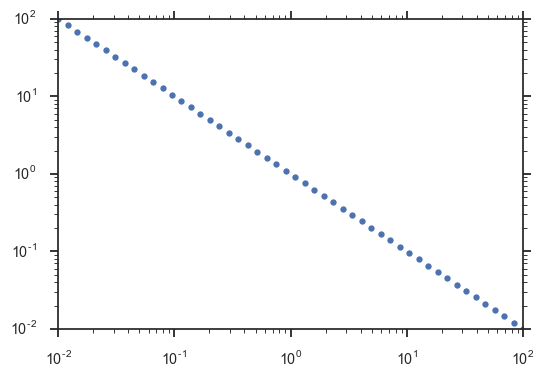

In [20]:
xs = np.logspace(-2, 2, 50)
ys = 1 / xs
plt.loglog(xs, ys, '.')